### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**The MiDaS v2 model for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>

In [1]:
import torch
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas.eval()

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2/model-f46da743.pt" to /root/.cache/torch/hub/checkpoints/model-f46da743.pt


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

will load the MiDaS v2 model. The model expects 3-channel RGB images of shape ```(3 x H x W)```. Images are expected to be normalized using
`mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`. 
`H` and `W` need to be divisible by `32`. For optimal results `H` and `W` should be close to `384` (the training resolution). 
We provide a custom transformation that performs resizing while maintaining aspect ratio. 

### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The model has been trained on 5 distinct dataset using 
multi-objective optimization to ensure high quality on a wide range of inputs.


### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f9570191eb8>)

Load the model

In [3]:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

Load transforms to resize and normalize the image

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [5]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

Predict and resize to original resolution

In [6]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
output = prediction.cpu().numpy()

Show result

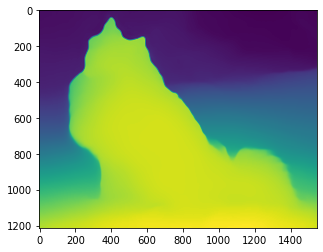

In [7]:
plt.imshow(output)
# plt.show()

### Reference
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

Please cite our paper if you use our model:

In [ ]:
@article{Ranftl2019,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {arXiv:1907.01341},
	year      = {2019},
}